# 3D transformation

In [16]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../settings.txt'))
print('\n')
# ------------------
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
from time import time
import cv2
import numpy as np
from os.path import join, isdir
sys.path.append('./../../easy_multi_person_pose_estimation')
sys.path.insert(0,'../')
import mvpose.data.transform as tfm

root = join(Settings['data_root'], 'pak')

from poseestimation import model
pe = model.PoseEstimator()

from pak.datasets.UMPM import UMPM
user = Settings['UMPM']['username']
pwd = Settings['UMPM']['password']

X, Y, Calib = tfm.get_from_umpm(root, 'p2_free_1', user, pwd)



UMPM


## Show found points


cam 1	elapsed: 43.87649178504944

cam 2	elapsed: 48.18397402763367

cam 3	elapsed: 47.41028904914856

cam 4	elapsed: 40.45591950416565


<Figure size 1152x936 with 0 Axes>

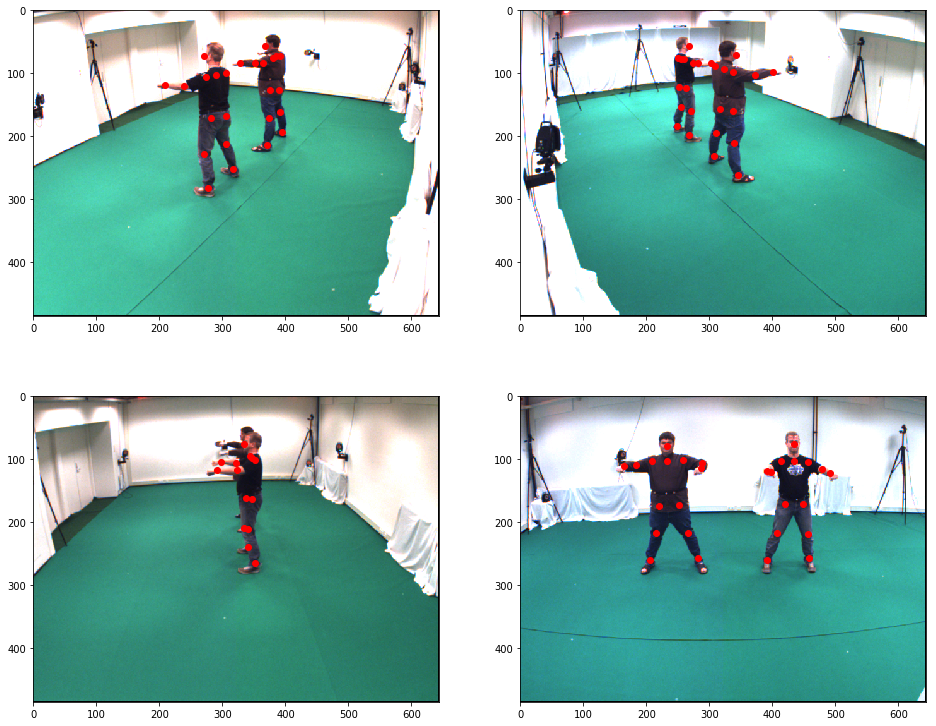

In [2]:
fig = plt.figure(figsize=(16,13))

def handle_img(ax, cam, frame):
    x = X[cam][frame]
    _start = time()
    positions = pe.predict(x)
    _end = time()
    print()
    print('cam ' + str(cam+1) + '\telapsed:', _end - _start)

    positions = tfm.transform_from_openpose(positions)
    positions_frame0 = positions[0]
    for k in positions_frame0:
        for x,y in k:
            if x > 0 and y > 0:
                ax.scatter(y,x, color='red')
    ax.imshow(X[cam][frame])
    return positions[0]
    
frame = 0
fig = plt.figure(figsize=(16,13))
pos_cam1 = handle_img(fig.add_subplot(221), 0, frame=frame)
pos_cam2 = handle_img(fig.add_subplot(222), 1, frame=frame)
pos_cam3 = handle_img(fig.add_subplot(223), 2, frame=frame)
pos_cam4 = handle_img(fig.add_subplot(224), 3, frame=frame)
plt.show()

## Generate 3D heatmaps

In [5]:
I = np.array([X[0][0], X[1][0], X[2][0], X[3][0]])
_start = time()
heatmaps, pafs = pe.predict_pafs_and_heatmaps(I)
_end = time(); print('elapsed:', _end - _start)

elapsed: 151.98411297798157


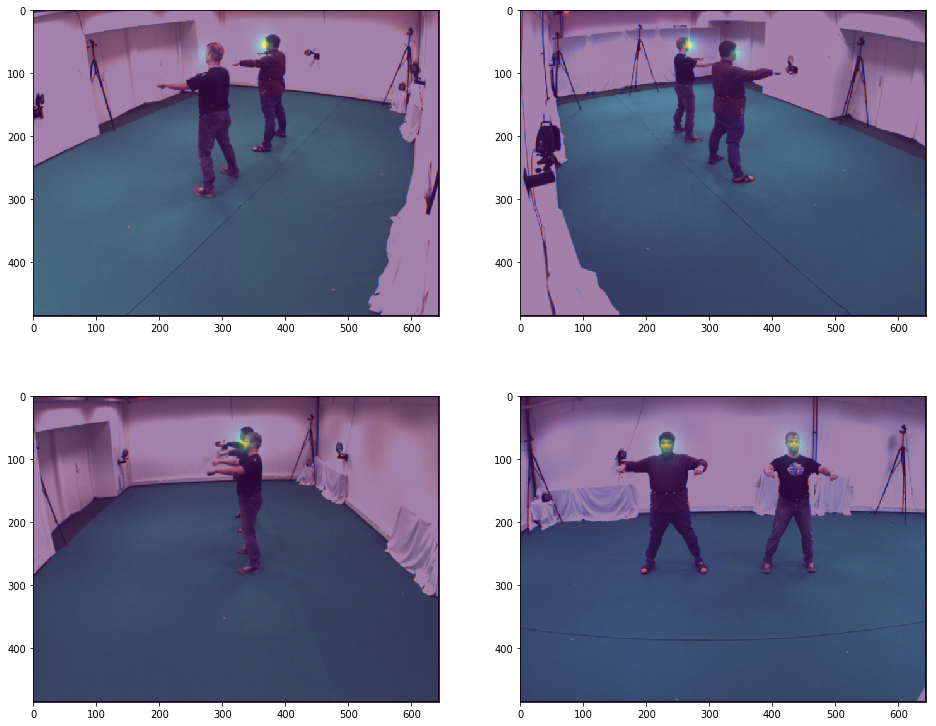

In [74]:
fig = plt.figure(figsize=(16,13))
Noses = []
for i,(hm,im) in enumerate(zip(heatmaps,I)):
    nose = hm[:,:,0]
    Noses.append(nose)
    ax = fig.add_subplot(2,2,i+1)
    ax.imshow(im); ax.imshow(nose, alpha=0.5)
plt.show()

Noses = np.array(Noses)

(79, 231)
(77, 435)


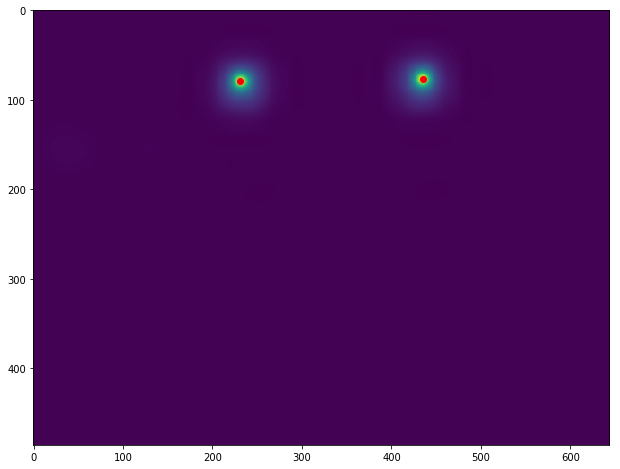

In [88]:
import skimage.feature as feat

nose1 = Noses[3]

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
ax.imshow(nose1)



for x,y in feat.peak_local_max(nose1, threshold_abs=0.1):
    ax.scatter(y,x, color='red')
    
plt.show()

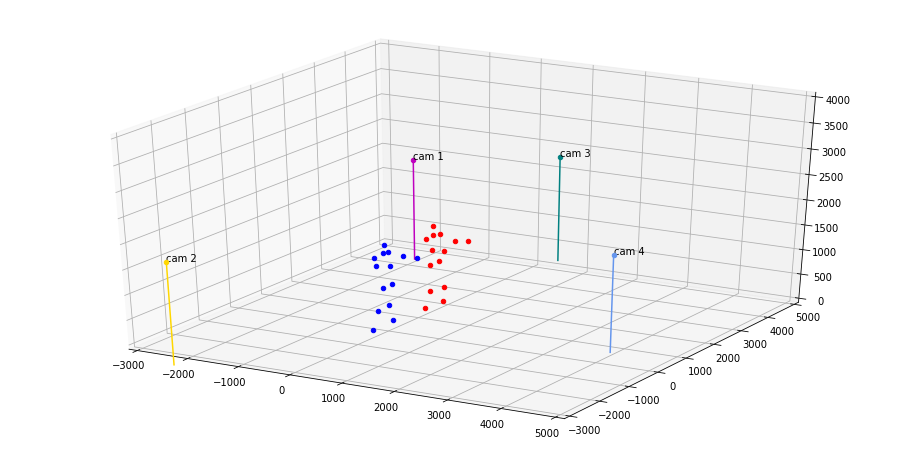

In [130]:
import numpy.linalg as la

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([-3000, 5000])
ax.set_ylim([-3000, 5000])
ax.set_zlim([0, 4000])


cam_color = ['m', 'gold', 'teal', 'cornflowerblue']
for i,cam in enumerate(Calib):
    R = cv2.Rodrigues(np.array(cam['rvec']))[0]
    t = np.array(cam['tvec'])
    x,y,z = -R.T @ t
    P = np.array([x,y,z])
    ax.scatter(x,y,z, color=cam_color[i])
    ax.text(x,y,z, 'cam ' + str(i+1))
    ax.plot([x,x], [y,y], [0,z], color=cam_color[i])



color = ['red', 'blue']
for x,y,z,pid in Y[0]:
    ax.scatter([x],[y],[z], color=color[int(pid)])


plt.show()